In [1]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [2]:
ticker = 'INTC'
data = yf.download(ticker, period='10y', interval='1d', auto_adjust=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2012-03-02,20.052155,20.149062,19.955250,20.067064,29632800
2012-03-05,20.059612,20.059612,19.649624,19.783802,32332200
2012-03-06,19.567632,19.850897,19.530361,19.835989,37196700
2012-03-07,19.813627,20.126709,19.768901,20.059620,32720900
2012-03-08,20.126702,20.156520,19.940344,20.007433,37261600
...,...,...,...,...,...
2022-02-23,45.169998,45.709999,44.549999,44.650002,38176700
2022-02-24,43.900002,46.790001,43.630001,46.720001,72740100
2022-02-25,46.930000,47.790001,46.250000,47.709999,39266300


In [3]:
prices = data.Close.values
prices

array([20.06706429, 19.78380203, 19.835989  , ..., 47.70999908,
       47.70000076, 46.81999969])

In [4]:
X = []
y = []

n_lags = 5
for step in range(len(prices) - n_lags):
    end_step = step + n_lags
    X.append(prices[step:end_step])
    y.append(prices[end_step])
    
X = np.array(X)
y = np.array(y)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).unsqueeze(dim=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_tensor, y_tensor, test_size=0.1, shuffle=False)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

In [7]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class Net(nn.Module):
    def __init__(self, inpit_size):
        super().__init__()
        self.linear1 = nn.Linear(inpit_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        x = self.dropout(F.relu(self.linear2(x)))
        x = self.linear3(x)
        
        return x

In [9]:
model = Net(n_lags).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
model

Net(
  (linear1): Linear(in_features=5, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
n_epochs = 1000
train_losses = np.zeros(n_epochs)
valid_losses = np.zeros(n_epochs)

for epoch in tqdm(range(n_epochs), desc='EPOCHES', leave=True):
    running_loss_train = 0
    running_loss_valid = 0
    
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(X_batch)
        loss = criterion(y_hat, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss_train += loss.item() * X_batch.size(0)
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses[epoch] = epoch_loss_train
    
    with torch.no_grad():
        model.eval()
        for X_val, y_val in valid_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(X_val)
            loss = criterion(y_hat, y_val)
            running_loss_valid += loss.item() * X_val.size(0)
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
        valid_losses[epoch] = epoch_loss_valid
         
    if (epoch+1) % max(1, int(n_epochs*0.1)) == 0:
        tqdm.write(f"Epoch:{epoch+1}/{n_epochs} | TrainLoss:{train_losses[epoch]:.2f} | ValidLoss:{valid_losses[epoch]:.2f}")
        torch.save(model.state_dict(), f'./ANN_{ticker}.pth')

EPOCHES:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:100/1000 | TrainLoss:13.37 | ValidLoss:11.12
Epoch:200/1000 | TrainLoss:11.14 | ValidLoss:12.32
Epoch:300/1000 | TrainLoss:10.47 | ValidLoss:7.52
Epoch:400/1000 | TrainLoss:9.27 | ValidLoss:19.42
Epoch:500/1000 | TrainLoss:8.98 | ValidLoss:18.55
Epoch:600/1000 | TrainLoss:8.68 | ValidLoss:25.02
Epoch:700/1000 | TrainLoss:8.49 | ValidLoss:13.44
Epoch:800/1000 | TrainLoss:8.44 | ValidLoss:9.40
Epoch:900/1000 | TrainLoss:7.24 | ValidLoss:9.36
Epoch:1000/1000 | TrainLoss:7.15 | ValidLoss:5.89


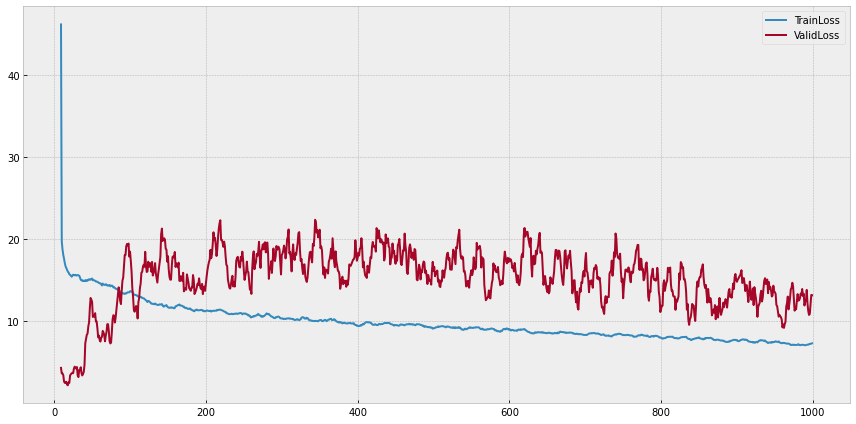

In [11]:
losses_df = pd.DataFrame(data={'TrainLoss':train_losses, 'ValidLoss':valid_losses})
losses_df.rolling(int(n_epochs*0.01)).mean().plot(figsize=(12,6))
plt.tight_layout()
plt.show()

In [12]:
trained_model = Net(n_lags).to(device)
trained_model.load_state_dict(torch.load(f'./ANN_{ticker}.pth'))
trained_model.eval()

predictions = []
validations = []

with torch.no_grad():
    for X_val, y_val in valid_loader:
        X_val = X_val.to(device)
        y_pred = trained_model(X_val)
        predictions.append(y_pred.cpu().numpy().flatten())
        validations.append(y_val.cpu().numpy().flatten())

predictions = np.concatenate(predictions)
validations = np.concatenate(validations)

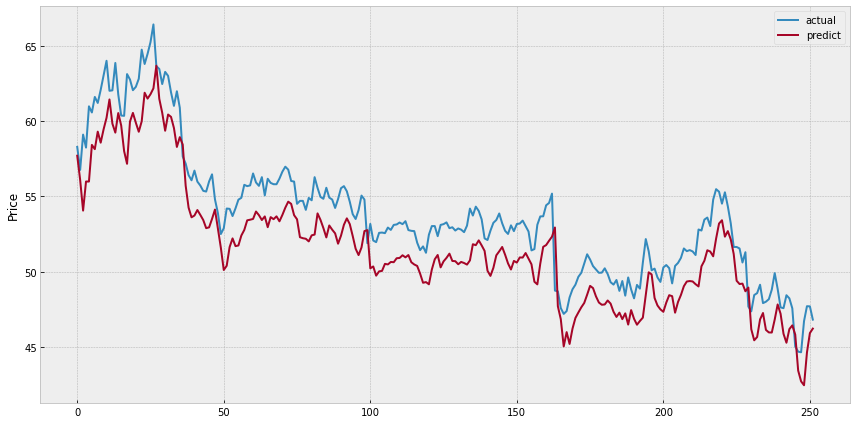

In [13]:
pred = pd.DataFrame(data={'actual':validations, 'predict':predictions})
pred.plot(figsize=(12,6))
plt.ylabel('Price')
plt.tight_layout()
plt.show()

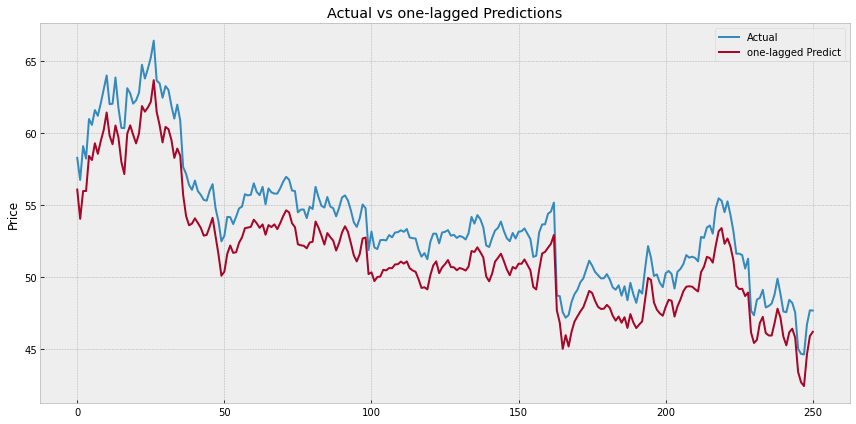

In [14]:
# predicted prices are just shifted actual prices

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(validations[:-1], label='Actual')
ax.plot(predictions[1:], label='one-lagged Predict')
ax.legend()
ax.set_ylabel('Price')
ax.set_title('Actual vs one-lagged Predictions')

plt.tight_layout()
plt.show()